In [136]:
# Load libraries
import pandas as pd
import pandas.api.types
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from xgboost import XGBRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
# Load data
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/train.csv")
data_test = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/BIOS 635 - ML/Midterm/test.csv")

# Data Preprocessing 

In [4]:
# Examine data
print(data.shape)
print(data_test.shape)
data.head()

(28800, 60)
(3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793
3,3,High,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,102.349
4,4,High,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,Permissive mismatched,Related,MEL,8.0,No,2.0,No,10.0,0.0,16.223


Since there are so many NaNs, we will replace the missing data.

In [127]:
# Replace missing data

# Check missing values
print(f"Number of rows with NaN in Train: {data.isnull().any(axis=1).sum()}")

# Fill numerical variables with median
for col in data.select_dtypes(include=['number']).columns:  
    data[col].fillna(data[col].median(), inplace=True)

# Fill categorical variables with mode
for col in data.select_dtypes(include=['object']).columns:  
    data[col].fillna(data[col].mode()[0], inplace=True)
    
# Check NaNs are removed
print(f"Number of rows with NaN in Train now: {data.isnull().any(axis=1).sum()}")

# Do the same preprocessing for test set
print(f"Number of rows with NaN in Test: {data_test.isnull().any(axis=1).sum()}")

for col in data_test.select_dtypes(include=['number']).columns:  
    data_test[col].fillna(data_test[col].median(), inplace=True)

for col in data_test.select_dtypes(include=['object']).columns:  
    data_test[col].fillna(data_test[col].mode()[0], inplace=True)
    
print(f"Number of rows with NaN in Test now: {data_test.isnull().any(axis=1).sum()}")

Number of rows with NaN in Train: 0
Number of rows with NaN in Train now: 0
Number of rows with NaN in Test: 0
Number of rows with NaN in Test now: 0


In [16]:
# Remove ID - unnecessary variable
data.drop(columns=['ID'], inplace=True)

# Identify numerical features
num_cols = data.select_dtypes(include=['number']).columns
num_cols = [col for col in num_cols if col not in ['efs', 'efs_time']]

# Standardize numerical features
stadardize = StandardScaler()
data[num_cols] = stadardize.fit_transform(data[num_cols])

In [18]:
# Define a function to calculate the survival rate
def transform_survival_rate(df, time='efs_time', event='efs'):
    """
    Transform the efs and efs_time data into survival rates using the Kaplan-Meier estimator.
    """
    kmf = KaplanMeierFitter()  # initalize estimator
    kmf.fit(df[time], df[event])  # fit the estimator
    survival_prob = kmf.survival_function_at_times(df[time]).to_numpy().flatten()  # calculate probabilites
    df["survival_rate"] = survival_prob  # add probabilities as new variable   
    return df

# Adding survival rate and risk score, the response variable
data = transform_survival_rate(data, "efs_time", "efs")
data['risk_score'] = np.log(data['survival_rate'] / (1 - data['survival_rate']))

data.head()

,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,...,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time,survival_rate,risk_score
0,N/A - non-malignant indication,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,42.356,0.458687,-0.165630
1,Intermediate,No,Intermediate,No,0.488048,0.610215,"TBI +- Other, >cGy",No,0.649549,Peripheral blood,...,"N/A, Mel not given",0.635255,No,0.583426,Yes,0.617168,1.0,4.672,0.847759,1.717134
2,N/A - non-malignant indication,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,19.793,0.462424,-0.150587
3,High,No,Intermediate,No,0.488048,0.610215,No TBI,No,0.649549,Bone marrow,...,"N/A, Mel not given",0.635255,No,0.583426,No,0.617168,0.0,102.349,0.456661,-0.173792
4,High,No,Poor,No,0.488048,0.610215,No TBI,No,0.649549,Peripheral blood,...,MEL,0.635255,No,0.583426,No,0.617168,0.0,16.223,0.464674,-0.141542


In [19]:
# Identify categorical features
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print(len(cat_cols))

# One-hot encoding
fixed_data = pd.get_dummies(data, columns=cat_cols, drop_first=True)
fixed_data.head()

35


,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,...,tce_div_match_GvH non-permissive,tce_div_match_HvG non-permissive,tce_div_match_Permissive mismatched,donor_related_Related,donor_related_Unrelated,"melphalan_dose_N/A, Mel not given",cardiac_Not done,cardiac_Yes,pulm_moderate_Not done,pulm_moderate_Yes
0,0.488048,0.610215,0.649549,0.632478,0.591564,0.516213,0.623256,0.520695,0.590556,0.479824,...,False,False,True,False,True,True,False,False,False,False
1,0.488048,0.610215,0.649549,0.632478,0.591564,0.516213,0.623256,0.520695,0.590556,0.479824,...,False,False,True,True,False,True,False,False,False,True
2,0.488048,0.610215,0.649549,0.632478,0.591564,0.516213,0.623256,0.520695,0.590556,0.479824,...,False,False,True,True,False,True,False,False,False,False
3,0.488048,0.610215,0.649549,0.632478,0.591564,0.516213,0.623256,0.520695,0.590556,0.479824,...,False,False,True,False,True,True,False,False,False,False
4,0.488048,0.610215,0.649549,0.632478,0.591564,0.516213,-0.245646,0.520695,0.590556,0.479824,...,False,False,True,True,False,False,False,False,False,False


In [53]:
# Kaggle given function for stratified C-index to evaluate model performance

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    event_label = 'efs'
    interval_label = 'efs_time'
    prediction_label = 'prediction'
    for col in submission.columns:
         if not pandas.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')
    # Merging solution and submission dfs on ID
    merged_df = pd.concat([solution, submission], axis=1)
    merged_df.reset_index(inplace=True)
    merged_df_race_dict = dict(merged_df.groupby(['race_group']).groups)
    metric_list = []
    for race in merged_df_race_dict.keys():
        # Retrieving values from y_test based on index
        indices = sorted(merged_df_race_dict[race])
        merged_df_race = merged_df.iloc[indices]
        # Calculate the concordance index
        c_index_race = concordance_index(
                        merged_df_race[interval_label],
                        -merged_df_race[prediction_label],
                        merged_df_race[event_label])
        metric_list.append(c_index_race)
    return float(np.mean(metric_list)-np.sqrt(np.var(metric_list)))

In [112]:
def strat_c_index(y_pred, data):
    """ 
    The score() function takes in the dataframes solution and submission and returns the C-index stratified on race. 
    """
    id_col_name = 'ID'
    
    # submission dataframe
    y_pred = {'prediction': y_pred}
    y_pred = pd.DataFrame(y_pred)
    y_pred.insert(0, id_col_name, range(len(y_pred)))
    
    # solution dataframe
    y_true = data[['efs', 'efs_time', 'race_group']].copy()
    y_true = pd.DataFrame(y_true)
    y_true.insert(0, id_col_name, range(len(y_true)))
    
    # drop index in case of misalignment from merging data in score()
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    
    # call score() to get stratified C-index
    index = score(y_true, y_pred, id_col_name)
    
    return index

# Method 1: Lasso

In [131]:
# Create a function for Lasso 
def lasso(X, y, k):
    # Grid search tuning to find best lambda using cross validation
    grid = 10 ** np.linspace(-4, 4, num=100)
    
    print("Training Lasso model with cross-validation...")
    
    lasso = LassoCV(alphas=grid, cv=k)
    lasso.fit(X, y)
    best_lambda = lasso.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Lasso model
    best_lasso = Lasso(alpha=best_lambda)
    best_lasso.fit(X, y)
    
    # Make predictions
    y_predicts = lasso.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    return y_predicts, mse, best_lasso

In [133]:
# Test different k fold cross validation 
lasso(X, y, 3)

Training Lasso model with cross-validation...
Best lambda: 0.0005336699231206312
MSE: 1.0757687315223627


(array([ 0.17255883,  0.3852924 , -0.19796576, ...,  1.07012292,
         0.37705778,  0.01156398]),
 1.0757687315223627,
 Lasso(alpha=0.0005336699231206312))

In [130]:
# Identify features (X) and response (y) variables 
X = fixed_data.drop(columns=['efs_time', 'efs', 'survival_rate', 'risk_score'])
y = fixed_data['risk_score']

# Run lasso
train_y_pred_lasso, train_mse_lasso, train_lasso = lasso(X, y)

# Calculate stratified C-index
strat_c_index(train_y_pred_lasso, data)

Training Lasso model with cross-validation...
Best lambda: 0.00021049041445120198
MSE: 1.0734495796282872


0.644621047742744

In [145]:
test_cat_col = data_test.select_dtypes(include=['object']).columns.tolist()
fixed_data_test = pd.get_dummies(data_test, columns=test_cat_col, drop_first=True)

In [147]:
data_test

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,Intermediate,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


In [146]:
fixed_data_test

,ID,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,...,prim_disease_hct_IEA,prod_type_PB,in_vivo_tcd_Yes,gvhd_proph_FKalone,gvhd_proph_Other GVHD Prophylaxis,sex_match_F-M,sex_match_M-F,race_group_More than one race,donor_related_Unrelated,pulm_moderate_Yes
0,28800,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,True,False,True,True,False,False,True,True,True,False
1,28801,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,True,False,False,True,False,False,False,False,True
2,28802,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,...,False,False,True,False,False,True,False,True,False,False


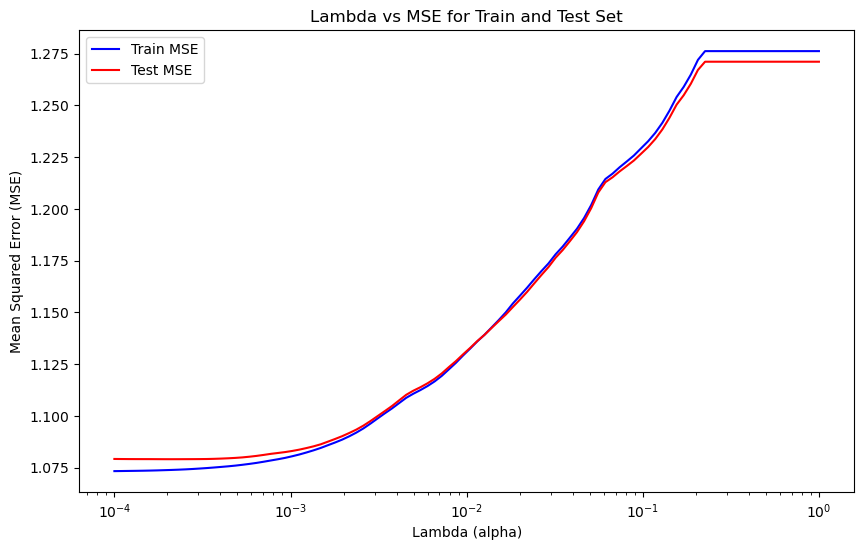

In [24]:
# One-hot encoding
test_cat_col = data_test.select_dtypes(include=['object']).columns.tolist()
fixed_data_test = pd.get_dummies(data_test, columns=test_cat_col, drop_first=True)

# Identify features and response variables for test set
X_test = fixed_data_test
y_test # doesn't exist....

# Plot lambda vs MSE for training and test sets
mse_train = []
mse_test = []

# Loop through the grid of alphas to compute MSE for each value of alpha
grid = 10 ** np.linspace(-4, 4, num=100)  
for alpha in grid:
    lasso = LassoCV(alphas=[alpha], cv=5)
    lasso.fit(X, y)
    y_train_pred = lasso.predict(X)
    y_test_pred = lasso.predict(X_test)
    
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))

# Plot MSE vs lambda
plt.figure(figsize=(10, 6))
plt.plot(grid, mse_train, label="Train MSE", color='blue')
plt.plot(grid, mse_test, label="Test MSE", color='red')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Lambda vs MSE for Train and Test Set')
plt.legend()
plt.show()

# Method 2: Ridge Regression

In [137]:
# Create a function for Ridge Regression
def ridge(X, y):
    # Grid search tuning to find best lambda using cross-validation
    grid = 10 ** np.linspace(-4, 4, num=100)  
    
    print("Training Ridge model with cross-validation...")
    
    ridge = RidgeCV(alphas=grid, cv=5)
    ridge.fit(X, y)
    best_lambda = ridge.alpha_
    print(f"Best lambda: {best_lambda}")
    
    # Get best Ridge model
    best_ridge = Ridge(alpha=best_lambda)
    best_ridge.fit(X, y)
    
    # Make predictions
    y_predicts = best_ridge.predict(X)

    # Calculate MSE of predictions
    mse = mean_squared_error(y, y_predicts)
    print(f"MSE: {mse}")
    
    return y_predicts, mse, best_ridge

In [138]:
# Run Ridge Reg
train_y_pred_ridge, train_mse_ridge, train_ridge = ridge(X, y)

# Calculate stratified C-index
strat_c_index(train_y_pred_ridge, data)

Training Ridge model with cross-validation...
Best lambda: 21.544346900318867
MSE: 1.0731796060290497


0.6448677479735924

In [144]:
print(np.var(y))

1.2747201169858011


In [143]:
num_zero_lasso = np.sum(train_lasso.coef_ == 0)
num_nonzero_ridge = np.sum(train_ridge.coef_ != 0)

print(f"Lasso zero coefficients: {num_nonzero_lasso}")
print(f"Ridge non-zero coefficients: {num_nonzero_ridge}")


Lasso zero coefficients: 19
Ridge non-zero coefficients: -0.8563367171855556


# Method 3: XGBoost

# Method 4: Cox Regression

# Plots

In [ ]:
# Create a plot comparing predicted risk scores across the race groups